In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
%matplotlib inline

In [28]:
def plot_pics(images=[], title=[]):
    rows, columns = 1, len(images)
    fig, plot_array = plt.subplots(rows, columns, figsize=(20,10))
    
    for index, plot in enumerate(plot_array.ravel()):
        plot.imshow(images[index], cmap='gray')
        if len(title) == 0 or len(title) != len(images):
            plot.set_title(index)
        else:
            plot.set_title(title[index])
    
    plt.draw()

mpimg.imread() **cv2.COLOR_RGB2GRAY**

cv2.imread() **cv2.COLOR_BGR2GRAY**

## Sobel Operator

find the **x-gradient** does a cleaner job of picking up the lane lines,but you can see the lines in the y-gradient as well.

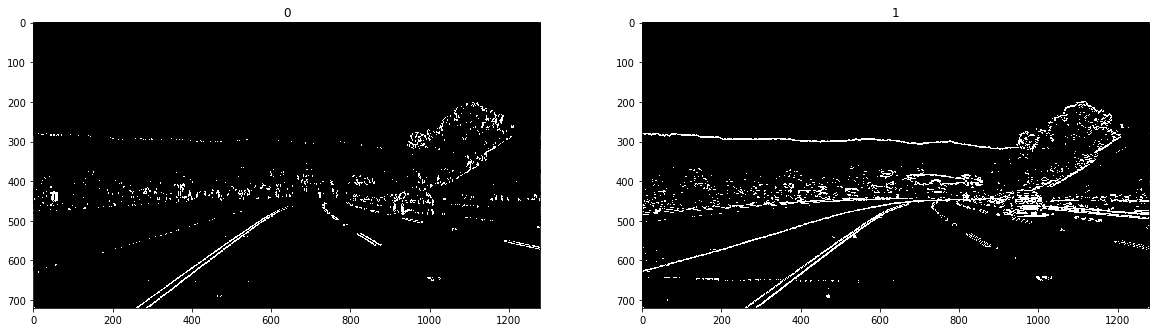

In [3]:
img = cv2.imread('./color_gradient/curved-lane.jpg')

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # convert to 8-bit (range from 0 to 255)
    # work the same on input images of different scales, like jpg vs. png
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

sobel_x = abs_sobel_thresh(img, 'x', 20, 100)
sobel_y = abs_sobel_thresh(img, 'y', 20, 100)
plot_pics([sobel_x, sobel_y])

## Magnitude of gradient

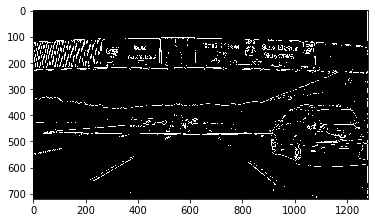

In [13]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Bigger kernel size can smooth over noisy intensity fluctuations on small scales
    # has to be odd number
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

image = cv2.imread('./color_gradient/signs_vehicles_xygrad.png')
img = mag_thresh(image, mag_thresh=(50, 100), sobel_kernel=3)
plt.imshow(img, cmap='gray')

## Direction of gradient

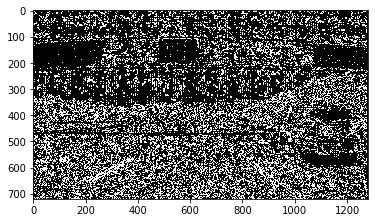

In [20]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

img = dir_threshold(image, thresh=(0.7, 1.3))
plt.imshow(img, cmap='gray')

## Combined

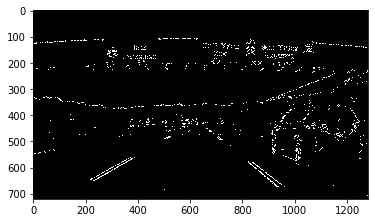

In [27]:
gradx = abs_sobel_thresh(image, 'x', 20, 100)
grady = abs_sobel_thresh(image, 'y', 20, 100)
mag_binary = mag_thresh(image, mag_thresh=(50, 100), sobel_kernel=3)
dir_binary = dir_threshold(image, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

# Color Space

## Gray Binary

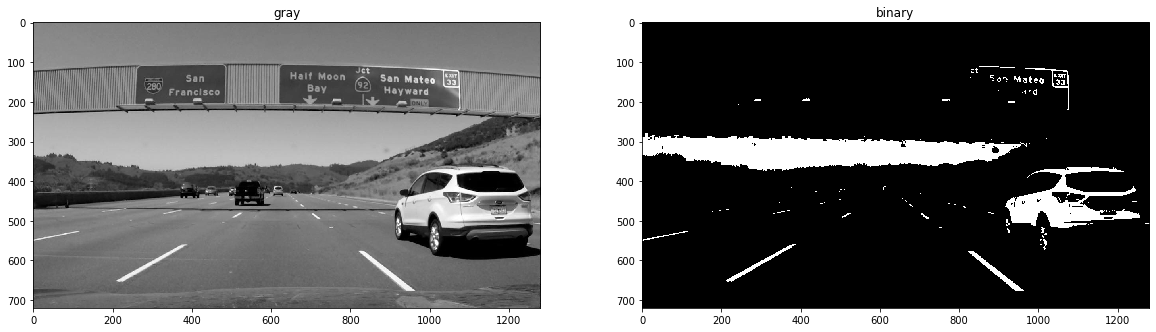

In [31]:
img = cv2.imread('./color_gradient/curved-lane.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

binary = np.zeros_like(gray); thresh = (180, 255)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

plot_pics([gray, binary], ['gray', 'binary'])

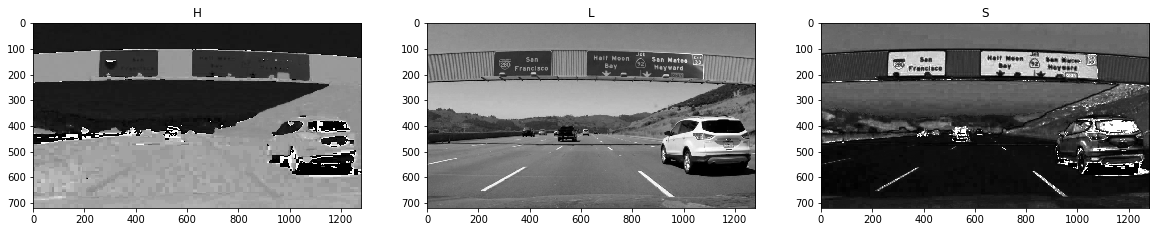

In [33]:
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]; L = hls[:,:,1]; S = hls[:,:,2]
plot_pics([H, L, S], ['H', 'L', 'S'])

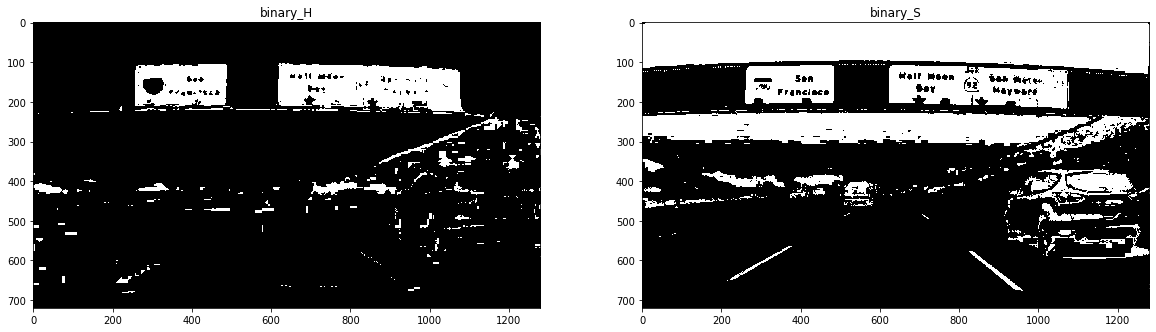

In [40]:
thresh = (30, 100); binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1

thresh = (90, 255); binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1

plot_pics([binary_H, binary_S], ['binary_H', 'binary_S'])
# S Channel is the best bet

## S-channel

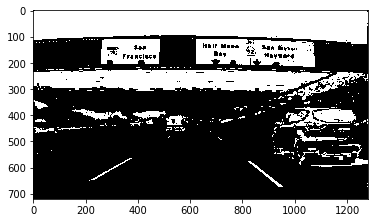

In [41]:
img = cv2.imread('./color_gradient/curved-lane.jpg')
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(90, 255))
plt.imshow(hls_binary, cmap='gray')

# Color and Gradient, combine Sobel and S-channel

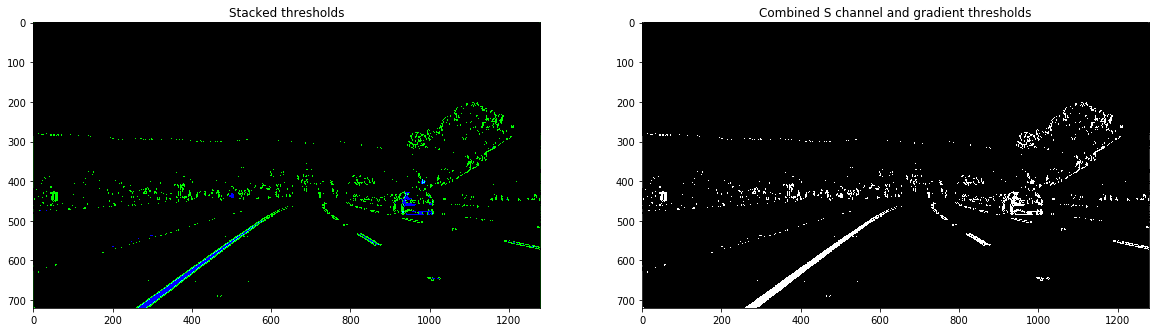

In [54]:
# Note: img is the undistorted image
img = cv2.imread('./color_gradient/curved-lane.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20; thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170; s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds'); ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds'); ax2.imshow(combined_binary, cmap='gray')

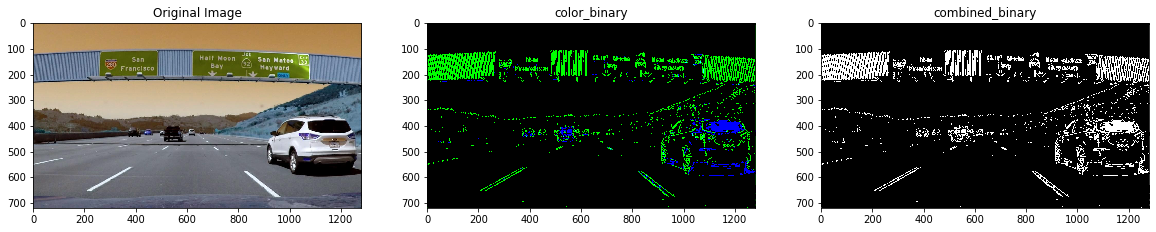

In [55]:
img = cv2.imread('./color_gradient/curved-lane.jpg')

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]; s_channel = hls[:,:,2]
    
    # Sobel x on l channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient, green annotation
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel, blue annotation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
color_binary, combined_binary = pipeline(image, s_thresh=(240, 255), sx_thresh=(20, 100))

# Plot the result
plot_pics([image, color_binary, combined_binary], ['Original Image', 'color_binary', 'combined_binary'])